# LAB 4: Electrocardiograms and Neural Networks

In this lab, we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients with sample rate 360 Hz. Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.

**NOTE 1:** GPU is required for this lab.
You must change "Runtime type" to GPU from the "Runtime" tab ("Change Runtime type").

**NOTE 2:** If you face RAM/memory overflow issue in this lab, ensure that you train only one model in single COLAB session. Feel free to implement your own memory optimization tricks too.

In [1]:
# Import lib
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal
from pywt import wavedec, dwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Load database
urllib.request.urlretrieve('https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
!unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

Archive:  mba_dataset.zip
replace mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Explore database**

We will primarily use \<patientID>.atr files (patientID is being 100, 101, etc.). There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal. Run the code below.

In [3]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols
    index = annotation.sample  # annotation index
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbols
print(f'Annotation indices: {index}')  # annotion indices of symbols for patient 

Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
The list of abnormal symbols are provided below, which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [4]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

**TASK 1 Data visualization (10 points)**: Plot any random 10-second long portion of this ECG file (patient 100). Then plot any 1-second portion of this ECG file (patient 100) which has an abnormality approximately in the middle of the signal.

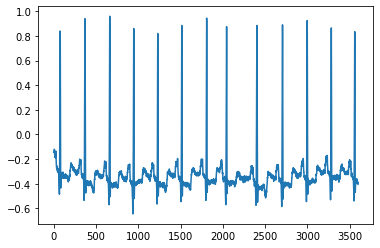

In [5]:
# The first 10 secs 
plt.plot(signal[0:3600])

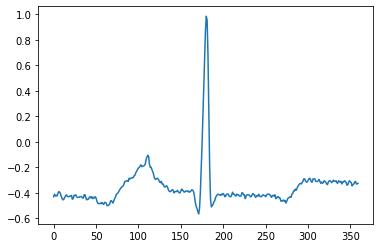

In [6]:
# As you can verify that at index[len(index)//2-30+19], the signal displays abnormality. 
plt.plot(signal[index[len(index)//2-30+19]-180:index[len(index)//2-30+19]+180])

**TASK 2 Data preparation (10 points)**: Training data or test data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N represents the number of training points, and D represents the data dimension. We will consider one data point as +/- 2 seconds sequence of samples centered around a Q wave (annotation). Therefore, $D = 4f$ , where $f$ is the sample rate. Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. You should get close to a total of 100k data points.  

**Here are the instructions for setting labels:**

**If your 4-second data contains at least one abnormal annotation, you need to set the label to 1.**



**Note 1:** Don't forget to ingore the non-beat symbols.

**Note 2:** Labels in abnormal list should all be set with label 1.

**Note 3:** The patients in the training set should be different from the patients in the test set. Split the patients roughly 70:30, or you can simply use the patient IDs that have been split into train/test which is given below.

In [7]:
# Splitted ID
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

In [8]:
# Your code here

def make_dataset():

  '''
  Output: X_train, y_train, X_test y_test
  '''

  X_train=[]
  y_train=[]

  X_test=[]
  y_test=[]

  for i in range(len(pts_train)):
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, pts_train[i]))
    for j in range(len(index)):
      # indentify the label of the Q-wave. Only gather the data if center is not non-beats
      if symbol[j] =="N":
        center=index[j]
        to_left=center-2*360
        to_right=center+2*360
        if to_left>=0 and to_right<=649999:
          X_train.append(signal[to_left:to_right])
          y_train.append(0)
      else:
        if symbol[j] in abnormal: 
          center=index[j]
          to_left=center-2*360
          to_right=center+2*360
          if to_left>=0 and to_right<=649999:
            X_train.append(signal[to_left:to_right])
            y_train.append(1)


  for i in range(len(pts_test)):
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, pts_test[i]))
    for j in range(len(index)):
      # indentify the label of the Q-wave. Only gather the data if center is not non-beats
      if symbol[j] =="N":
        center=index[j]
        to_left=center-2*360
        to_right=center+2*360
        if to_left>=0 and to_right<=649999:
          X_test.append(signal[to_left:to_right])
          y_test.append(0)
      else:
        if symbol[j] in abnormal: 
          center=index[j]
          to_left=center-2*360
          to_right=center+2*360
          if to_left>=0 and to_right<=649999:
            X_test.append(signal[to_left:to_right])
            y_test.append(1)
  return np.array(X_train),np.array(y_train),np.array(X_test),np.array(y_test)


X_train,y_train,X_test,y_test=make_dataset()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70263, 1440) (70263,) (38954, 1440) (38954,)


**Task 3 Feature extraction (10 points)**: You will use Signal Processing lib [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to extract features for training and testing data matrices. We will do short-time Fourier transform to extract the spectrogram of ECG signal. 

**Note 1:** A common format of spectrogram is a graph with two geometric dimensions: one axis represents time, and the other axis represents frequency; a third dimension indicating the amplitude of a particular frequency at a particular time is represented by the intensity or color of each point in the image.

Examples of ECG spectrogram are shown below:

![ECG_spetrogram.jpg](https://d3i71xaburhd42.cloudfront.net/c86f76b6eeaa1ae92e5c96a68ca47d046fc01b2e/3-Figure2-1.png)

M. Salem, S. Taheri and J. Yuan, "ECG Arrhythmia Classification Using Transfer Learning from 2- Dimensional Deep CNN Features," 2018 IEEE Biomedical Circuits and Systems Conference (BioCAS), Cleveland, OH, USA, 2018, pp. 1-4, doi: 10.1109/BIOCAS.2018.8584808.


In [9]:
def extract_features(X):
  '''
  Input: X (N x D): Input data matrix
  Output: F (N x Frequecny x time): Feature matrix
  '''
  f, t, Zxx = scipy.signal.stft(X)

  return Zxx
  

F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)

(70263, 129, 13) (38954, 129, 13)


**Task 4 Distribution and compensation for imbalance (10 points)**: Plot the distribution of percentage of oberservations with normal and abnormal labels in training set. Is the dataset balanced? If not, how could you deal with this imbalanced dataset during training?

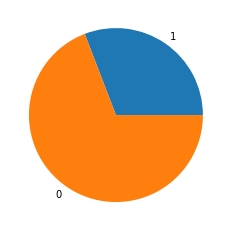

<AxesSubplot:title={'center':'label_count_fater_oversampling'}>

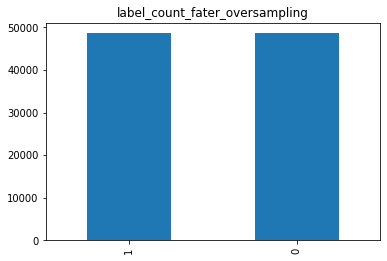

In [10]:
# Your code here
plt.pie([sum(y_train)/len(y_train),1-sum(y_train)/len(y_train)],labels =["1","0"] )
plt.show()
# Your solution if imbalanced
# It is obvious that the class here is imbalanced, therefore we can use oversampling to tackle this problem.

# Make a dataframe which will facilitate sampling 
make_df=pd.DataFrame(X_train)
make_df["label"]=pd.Series(y_train)
# segregate data based on the class
class_1=make_df[make_df["label"]==1]
class_0=make_df[make_df["label"]==0]
# Count the majority class
class_0_count=len(class_0)
# Oversampling class 1
class_1_over = class_1.sample(class_0_count, replace=True)
balanced_train = pd.concat([class_1_over, class_0], axis=0)
# Display the result
balanced_train['label'].value_counts().plot(kind='bar', title='label_count_fater_oversampling')

In [11]:
# Re-extract the feature
X_train=np.array(balanced_train.iloc[:,:-1])
y_train=np.array(balanced_train.iloc[:,-1])

F_train = extract_features(X_train)

In [12]:
# New extracted feature! 
F_train.shape

(97190, 129, 13)

**TASK 5 LSTM (25 points)**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA). 

**Task 5.1:** Using Pytorch, create a single layer Bidirectional LSTM model. Followed by LSTM layer, you should have linear layer with sigmoid activation and a single output (we are predicting Normal/Abnormal).

**Task 5.2:** While creating your LSTM model, how could you validate your model in a real scientific experiment? (Describe and comment it in a text cell)

**Task 5.3:** Train and test your model, report your accuracy and F1-score on test set and train set. (You can find the definition and formula of accuracy, precision, recall-rate, and f1-score from this [link](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6))

**Task 5.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Note 1:** Print the loss function and accuracy while training to make sure your model works. 

**Note 2:** You need to add a flattening layer after LSTM layer (and before linear layer). 

**Note 3:** The output of LSTM in pytorch lib have a tuple outout, add the following GetLSTMOutput after your layer. If your model doesn't have this problem, you can ignore this.

### Answer to 5.2 

In a real scientific experiment, I would divide the training set into training and validation set. During the training, we should keep looking at how our model is performing on the validation set, to aviod overfitting issue.  In the mean time, I would also shuffle the dataset and perform k-fold cross-validation tune the best hyper-parameters. Cross-validation could help the model avoid overfitting and selection bias. 

### Answer to 5.3

# Train

train Accuracy of the model on the test images: 97.13447885584937 %

recall:  0.9649346640600884

precision:  0.9774660218460769

F1: 0.9711599200555056

# Test

Test Accuracy of the model on the test images: 73.52261641936643 %

recall:  0.4549257972844964

precision:  0.6283253379851723

F1: 0.5277472527472528

### Answer to 5.4

I think we can work on the topology and hyperparameters of the model. For instance, we can increase the number of layers and nurons to make the model better at capturing key information. 

We can also tune the learning rate and change the type of the optimizer to improve the accuracy. 

Using BI-LSTM with 4 layers.  1000 more Epochs.  60 hidden Neurons

Test Accuracy of the model on the test images: 73.52261641936643 %

recall: 0.7549257972844964

precision: 0.8283253379851723

F1: 0.7899241658625399



In [14]:
import torch
import torch.nn as nn

In [34]:
# Layer after LSTM
class GetLSTMOutput(nn.Module):
    def forward(self, x):
        out,_ = x
        return out

In [15]:
# Adapt your input to tensor
F_train = torch.from_numpy(F_train).float()
F_test= torch.from_numpy(F_test).float()
y_train = torch.from_numpy(y_train).float()

<ipython-input-15-daba87a7cf82>:2: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:250.)
  F_train = torch.from_numpy(F_train).float()


In [16]:
F_train=F_train.to("cuda")
y_train=y_train.to("cuda")

In [18]:
F_test=F_test.to("cuda")
y_test=y_test.to("cuda")

In [17]:
y_test= torch.from_numpy(y_test).float()
F_train=torch.permute(F_train, (0, 2, 1))
F_test=torch.permute(F_test, (0, 2, 1))

In [156]:
model=nn.Sequential(nn.LSTM(129, 30, 1, batch_first=True,bidirectional=True),GetLSTMOutput(),
    nn.Linear(30*2, 1),nn.Sigmoid())

In [157]:
model=model.to("cuda")

In [158]:
criterion =  nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [159]:
for epoch in range(3000):
  optimizer.zero_grad()
  output_tensor=model(F_train)
  loss=criterion(torch.squeeze(output_tensor[:,-1,:]),y_train)
  loss.backward()
  optimizer.step()

  print(epoch)

  print(loss.item())

Streaming output truncated to the last 5000 lines.
500
0.20393961668014526
501
0.20377230644226074
502
0.20361527800559998
503
0.20343001186847687
504
0.20328719913959503
505
0.20309771597385406
506
0.20295901596546173
507
0.20277278125286102
508
0.2026253193616867
509
0.2024550586938858
510
0.2022947520017624
511
0.2021358162164688
512
0.20196610689163208
513
0.2018159180879593
514
0.20164622366428375
515
0.2014937698841095
516
0.2013305127620697
517
0.20116929709911346
518
0.20101243257522583
519
0.20085063576698303
520
0.20069704949855804
521
0.20053362846374512
522
0.20038090646266937
523
0.20022085309028625
524
0.20006045699119568
525
0.19990582764148712
526
0.19974450767040253
527
0.19958987832069397
528
0.19943226873874664
529
0.19927377998828888
530
0.1991184800863266
531
0.19896043837070465
532
0.19880452752113342
533
0.19864724576473236
534
0.19849148392677307
535
0.19833630323410034
536
0.19817698001861572
537
0.1980232298374176
538
0.19786880910396576
539
0.1977103650569915

In [166]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_train).item()
    classified_1=0
    for i in range(len(F_train)):
      inputs=F_train[i,:,:].to("cuda")
      label =y_train[i].to("cuda")
      outputs = model(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('train Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

train Accuracy of the model on the test images: 97.13447885584937 %
recall:  0.9649346640600884
precision:  0.9774660218460769
F1: 0.9711599200555056


In [218]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_test).item()
    classified_1=0
    for i in range(len(F_test)):
      inputs=F_test[i,:,:].to("cuda")
      label =y_test[i].to("cuda")
      outputs = model(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

Test Accuracy of the model on the test images: 73.52261641936643 %
recall:  0.4549257972844964
precision:  0.6283253379851723
F1: 0.5277472527472528


**TASK 6 1-D CNNs (25 points)**: Different to LSTM model, we will have [1D CNN](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) layer with ReLU activation. You need to add a flattening layer just after this (and before linear layer).

**Task 6.1:** Using Pytorch, create a deep CNN model (more than 1 layer). Followed by CNN layer, you should have one or several linear layers with different kinds of activation and number of final output units equals to 1.

**Task 6.2:** While creating your deep CNN model, how do you validate your model? (Describe and comment it in a text cell)

**Task 6.3:** Train and test your model, report your accuracy and F1-score on test set and train set.

**Task 6.4:** What do you think is a way to increase the accuracy and F1-score? Try it and show if it is helpful.

**Task 6.5:** Comment the difference between your CNN and LSTM models.

**Note 1:** Print the loss function and accuracy while training to make sure your model works. 

**Note 2:** You need to add a flattening layer after CNN layer (and before linear layer). 

**Note 3:** Sigmoid is recommended as the activation of your last linear layer.

### Answer to Task 6.2

I would create another independent validation set which is taken from our training set. Stop the training when the validation score start decreasing

### Answer to Task 6.3

# Train Report

train Accuracy of the model on the test images: 89.65840107006893 %

recall:  0.8817985389443358

precision:  0.9086687306501547

F1: 0.8950320094409574


# Test Report

Test Accuracy of the model on the test images: 72.12609744827232 %

recall:  0.4595042627091885

precision:  0.592046379170057

F1: 0.5174222222222222

### Answer to Task 6.4

I say we can increase number of epochs for the training. 

Indeed, it is better:

Test Accuracy of the model on the test images: 74.9319710427684 %

recall:  0.4900536785601516

precision:  0.6525806790707454

F1: 0.5597583517424822

### Answer to Task 6.5

Of course, a simple CNN is worse than LSTM(after tune the parameters). The reason is that LSTM is good at capturing long-term dependency than a simple CNN could do. 

In [216]:
# CODE HERE
# nn.Sequential()

model_cnn=nn.Sequential(
    nn.Conv1d(13,16,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2,stride=2),
    nn.Conv1d(16,32,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(1024,200),
    nn.ReLU(),
    nn.Linear(200,1),
    nn.Sigmoid()
)
model_cnn=model_cnn.to("cuda")

In [212]:
F_train.shape

torch.Size([97190, 13, 129])

In [241]:
criterion =  nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.00003)
for epoch in range(5000):
  optimizer.zero_grad()
  output_tensor=model_cnn(F_train)

  loss=criterion(torch.squeeze(output_tensor),y_train)
  loss.backward()
  optimizer.step()

  print(epoch)

  print(loss.item())

Streaming output truncated to the last 5000 lines.
2500
0.14261141419410706
2501
0.14258389174938202
2502
0.14255596697330475
2503
0.14252816140651703
2504
0.14250005781650543
2505
0.14247217774391174
2506
0.14244444668293
2507
0.14241664111614227
2508
0.14238892495632172
2509
0.14236116409301758
2510
0.142333522439003
2511
0.14230568706989288
2512
0.1422780156135559
2513
0.14225012063980103
2514
0.14222237467765808
2515
0.1421947330236435
2516
0.14216697216033936
2517
0.1421392560005188
2518
0.14211152493953705
2519
0.14208382368087769
2520
0.14205604791641235
2521
0.14202836155891418
2522
0.14200055599212646
2523
0.1419728547334671
2524
0.14194507896900177
2525
0.14191755652427673
2526
0.1418897807598114
2527
0.14186206459999084
2528
0.14183439314365387
2529
0.1418067067861557
2530
0.14177900552749634
2531
0.1417512744665146
2532
0.14172352850437164
2533
0.14169573783874512
2534
0.1416682004928589
2535
0.14164040982723236
2536
0.14161263406276703
2537
0.1415848433971405
2538
0.141557

In [243]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_train).item()
    classified_1=0
    for i in range(len(F_train)):
      if i<len(F_train)-1:
        inputs=F_train[i:i+1,:,:].to("cuda")
      else:
        inputs=F_train[-1:,:,:].to("cuda")
      label =y_train[i].to("cuda")
      outputs = model_cnn(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('train Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

train Accuracy of the model on the test images: 97.11287169461879 %
recall:  0.9674657886613849
precision:  0.9746056095690209
F1: 0.9710225747154925


In [244]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_test).item()
    classified_1=0
    for i in range(len(F_test)):
      if i<len(F_test)-1:
        inputs=F_test[i:i+1,:,:].to("cuda")
      else:
        inputs=F_test[-1:,:,:].to("cuda")
      label =y_test[i].to("cuda")
      outputs = model_cnn(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

Test Accuracy of the model on the test images: 74.9319710427684 %
recall:  0.4900536785601516
precision:  0.6525806790707454
F1: 0.5597583517424822


**Task 7 Alexnet (10 points):** AlexNet is a deep convolutional neural network (CNN) designed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, which achieved a significant breakthrough in the field of computer vision by winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. It was one of the first deep neural networks to use multiple layers and dropout regularization to prevent overfitting. You can find the introduction of Alexnet in this paper ["ImageNet Classification with Deep Convolutional
Neural Networks"](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

**Task 7.1**: Establish and train a AlexNet which is similiar to the AlexNet of the paper: ["Classification of ECG signal using FFT based improved Alexnet classifier"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9514660/) The structure of Alex Net is shown below.

**Task 7.2**: Train and test AlexNet, report accuracy and F1-score on test set and train set.

**Note 1**: If you think the features are too less for so many layers, you can use one conv layer to replace conv 3 - conv 5 and one linear layer to replace FC 6 - FC 8.

**Note 2**: You can add dropout layer if needed. 

**Note 3**: You can set hyperparameters yourself.

![AlexNet](https://www.ncbi.nlm.nih.gov/corecgi/tileshop/tileshop.fcgi?p=PMC3&id=166618&s=150&r=1&c=1)

Kumar M A, Chakrapani A. Classification of ECG signal using FFT based improved Alexnet classifier. PLoS One. 2022;17(9):e0274225. Published 2022 Sep 27. doi:10.1371/journal.pone.0274225

In [28]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(13, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv1d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv1d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 100),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(100, num_classes))
        self.sig=nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return self.sig(out)

In [29]:
model_alex=AlexNet().to("cuda")

In [30]:
criterion =  nn.BCELoss()
optimizer = torch.optim.Adam(model_alex.parameters(), lr=0.00003)
for epoch in range(200):
  optimizer.zero_grad()
  output_tensor=model_alex(F_train)

  loss=criterion(torch.squeeze(output_tensor),y_train)
  loss.backward()
  optimizer.step()

  print(epoch)

  print(loss.item())

0
0.6969807744026184
1
0.6918388605117798
2
0.6868870258331299
3
0.6825131773948669
4
0.6781200170516968
5
0.6738004088401794
6
0.6695790886878967
7
0.6660297513008118
8
0.66131591796875
9
0.6569098830223083
10
0.6518555879592896
11
0.6474205851554871
12
0.6423736214637756
13
0.6368535757064819
14
0.6319878697395325
15
0.6259298920631409
16
0.6199451088905334
17
0.6141461730003357
18
0.6080731749534607
19
0.6006734371185303
20
0.5942941904067993
21
0.5879726409912109
22
0.5811464190483093
23
0.5733870267868042
24
0.566216230392456
25
0.5579974055290222
26
0.5499560236930847
27
0.5429288744926453
28
0.5344903469085693
29
0.5263667106628418
30
0.5182785391807556
31
0.5105182528495789
32
0.501818060874939
33
0.4936203360557556
34
0.48582684993743896
35
0.4776199460029602
36
0.4682775139808655
37
0.46073320508003235
38
0.453080952167511
39
0.44408681988716125
40
0.4357459545135498
41
0.4275690019130707
42
0.4184618294239044
43
0.41100043058395386
44
0.40309521555900574
45
0.394926697015762

In [31]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_train).item()
    classified_1=0
    for i in range(len(F_train)):
      if i<len(F_train)-1:
        inputs=F_train[i:i+1,:,:].to("cuda")
      else:
        inputs=F_train[-1:,:,:].to("cuda")
      label =y_train[i].to("cuda")
      outputs = model_alex(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('train Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

train Accuracy of the model on the test images: 68.8568782796584 %
recall:  0.4880954830743904
precision:  0.8147779189996909
F1: 0.6104805291740664


In [32]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_test).item()
    classified_1=0
    for i in range(len(F_test)):
      if i<len(F_test)-1:
        inputs=F_test[i:i+1,:,:].to("cuda")
      else:
        inputs=F_test[-1:,:,:].to("cuda")
      label =y_test[i].to("cuda")
      outputs = model_alex(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

Test Accuracy of the model on the test images: 69.36899933254608 %
recall:  0.2252131354594253
precision:  0.5740442655935614
F1: 0.32350606644744295


**Task 8 Bonus (20 points)**: You can choose between task 8.1 and task 8.2 to get all bonus credits.

**Task 8.1**: In this task, you need to reconstruct the matrix for training and test data. As described before, each R wave in the database is annotated with normal or abnormal label. We will consider as an observation a time period with totally five Q waves centered around a Q wave with a annotation (normal/abnormal).Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. After data preparation, You need to repeat task 3, task 4, task 5 and task 6 with your new data.

**Note 1**: Each of your observation may have different length of data, you need to padding them while training CNN model in task6.

**Task 8.2**: Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, [introduced in 2014 by Kyunghyun Cho et al](https://arxiv.org/abs/1409.1259). You need to create your own GRUs, train and test the model, and report accuracy and F1-score on train set and test set. Compare the results of GRUs with results of LSTM and CNN, what do you observe?

### TASK 8.2

I think GRU is as good as LSTM, but it is easier to be trained upon, and make faster inference.

In [41]:
# Your code 

model=nn.Sequential(nn.GRU(129, 80, 3, batch_first=True),GetLSTMOutput(),
    nn.Linear(80, 1),nn.Sigmoid())
model=model.to("cuda")
criterion =  nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
for epoch in range(1000):
  optimizer.zero_grad()
  output_tensor=model(F_train)
  loss=criterion(torch.squeeze(output_tensor[:,-1,:]),y_train)
  loss.backward()
  optimizer.step()

  print(epoch)

  print(loss.item())


0
0.6941425800323486
1
0.696000337600708
2
0.6921411752700806
3
0.6913907527923584
4
0.6914495229721069
5
0.6901338696479797
6
0.6882020235061646
7
0.6868689656257629
8
0.686219334602356
9
0.6856786012649536
10
0.6861857175827026
11
0.6847007870674133
12
0.6834151148796082
13
0.6831793785095215
14
0.6828214526176453
15
0.6819499731063843
16
0.6807681918144226
17
0.6792529225349426
18
0.6770493388175964
19
0.6749945282936096
20
0.6720495820045471
21
0.6673456430435181
22
0.6607842445373535
23
0.652876615524292
24
0.6406603455543518
25
0.627009928226471
26
0.6374061703681946
27
0.6915469169616699
28
0.6117938756942749
29
0.6456430554389954
30
0.6340027451515198
31
0.6188812851905823
32
0.6165372133255005
33
0.6174732446670532
34
0.6164491772651672
35
0.610978364944458
36
0.6048083901405334
37
0.6029370427131653
38
0.5994403958320618
39
0.5868365168571472
40
0.5768736004829407
41
0.5802743434906006
42
0.5766419172286987
43
0.5648313164710999
44
0.5636385679244995
45
0.5643599033355713
46


In [42]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_train).item()
    classified_1=0
    for i in range(len(F_train)):
      inputs=F_train[i,:,:].to("cuda")
      label =y_train[i].to("cuda")
      outputs = model(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('train Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

train Accuracy of the model on the test images: 97.81047432863463 %
recall:  0.9725691943615599
precision:  0.9834571446407391
F1: 0.9779828663659313


In [43]:
with torch.no_grad():
    correct = 0
    total = 0
    correct_1=0
    total_1=sum(y_test).item()
    classified_1=0
    for i in range(len(F_test)):
      inputs=F_test[i,:,:].to("cuda")
      label =y_test[i].to("cuda")
      outputs = model(inputs)
      outputs=torch.squeeze(outputs[-1:])
      if outputs.item()<0.5:
        outputs=0.0
      else:
        outputs=1.0
      total += 1
      if outputs==label.item():
        correct+=1
      
      if label.item()==1.0 and outputs==1.0:
        correct_1+=1

      if outputs==1:
        classified_1+=1



    precision=(correct_1/classified_1)
    recall=(correct_1/total_1)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total)) 
    print("recall: ",(correct_1/total_1))
    print("precision: ",(correct_1/classified_1))
    print("F1:",2*((precision*recall)/(precision+recall)))

Test Accuracy of the model on the test images: 70.40098577809724 %
recall:  0.44892642879696876
precision:  0.5555881203595154
F1: 0.49659448131330775


**You are ready to submit in Blackboard!**

Please suffix your colab file with _<jhID> 
o	eg: Lab4_ECG_LSTM_CNN_myjhID12

